<a href="https://www.kaggle.com/code/hebaatef/signature-classification-siamese-network?scriptVersionId=124674462" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.6.2', '1.20.3')

## Reading the Dataset
We're reading the folders and splitting them into train and test set for training purposes.

In [2]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [3]:
!ls /kaggle/input/signature-dataset-new/personA

Test  Train


In [4]:
ROOT = "/kaggle/input/signature-dataset-new"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
    return image

In [5]:
def split_dataset(directory):
    folders = os.listdir(directory)
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    for folder in folders:
        # Creating Train-list
        num_files = len(os.listdir(os.path.join(directory, folder+'/Train')))
        train_list[folder+'/Train'] = num_files-1
        
        num_files = len(os.listdir(os.path.join(directory, folder+'/Test')))
        test_list[folder+'/Test'] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)
print("\nTrain List:", train_list)


Length of training list: 5
Length of testing list : 5

Test List: {'personD/Test': 9, 'personA/Test': 9, 'personC/Test': 9, 'personE/Test': 9, 'personB/Test': 9}

Train List: {'personD/Train': 40, 'personA/Train': 40, 'personC/Train': 40, 'personE/Train': 40, 'personB/Train': 40}



## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [6]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        person_type = folder.split('/')
        path = os.path.join(directory, folder)
#         files = list(os.listdir(path))[:max_files]
        labels = pd.read_csv(path + '/' + person_type[0] + '_SigVerification'+ person_type[1] + 'Labels.csv')
        real_labels = labels[labels['label'] == 'real']
        forged_labels = labels[labels['label'] == 'forged']
        num_files = len(real_labels.iloc[:max_files]) - 1
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, real_labels.iloc[i,0])
                positive = (folder, real_labels.iloc[j,0])
                neg_file = random.randint(0, len(forged_labels)-1)
                negative = (folder, forged_labels.iloc[neg_file,0])

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [7]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 180
Number of testing triplets : 15

Examples of triplets:
(('personC/Train', 'personC_18.png'), ('personC/Train', 'personC_27.png'), ('personC/Train', 'personC_42.png'))
(('personE/Train', 'personE_34.png'), ('personE/Train', 'personE_33.png'), ('personE/Train', 'personE_12.png'))
(('personA/Train', 'personA_36.png'), ('personA/Train', 'personA_41.png'), ('personA/Train', 'personA_11.png'))
(('personB/Train', 'personB_15.png'), ('personB/Train', 'personB_8.png'), ('personB/Train', 'personB_5.png'))
(('personD/Train', 'personD_8.png'), ('personD/Train', 'personD_18.png'), ('personD/Train', 'personD_11.png'))


## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [8]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
#         print(anchor)
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

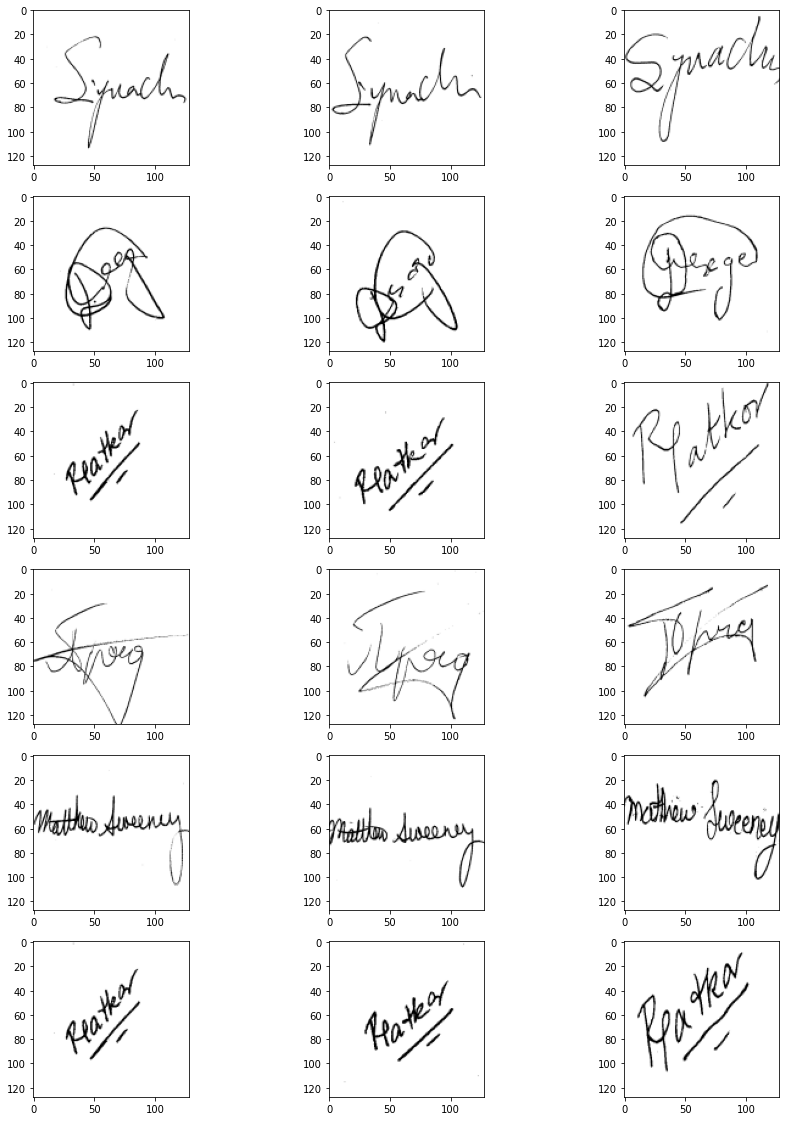

In [9]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [10]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [11]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

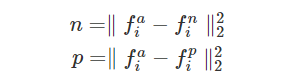

In [12]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                   

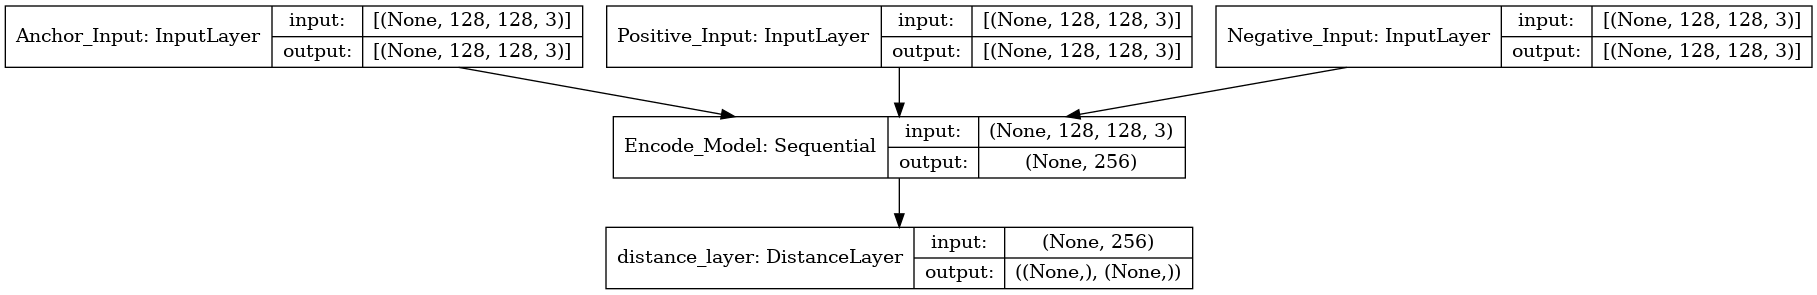

In [13]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [14]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [15]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [16]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [17]:
save_all = False
epochs = 10
batch_size = 10

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
#         print(len(data[0]))
        if len(data[0]) == 0:
            break
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
        
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 17 sec)
Loss on train    = 0.66375
Accuracy on test = 0.60000

EPOCH: 2 	 (Epoch done in 4 sec)
Loss on train    = 0.15916
Accuracy on test = 0.73333

EPOCH: 3 	 (Epoch done in 4 sec)
Loss on train    = 0.01346
Accuracy on test = 0.80000

EPOCH: 4 	 (Epoch done in 4 sec)
Loss on train    = 0.00560
Accuracy on test = 0.80000

EPOCH: 5 	 (Epoch done in 4 sec)
Loss on train    = 0.00057
Accuracy on test = 0.73333

EPOCH: 6 	 (Epoch done in 4 sec)
Loss on train    = 0.00000
Accuracy on test = 0.80000

EPOCH: 7 	 (Epoch done in 4 sec)
Loss on train    = 0.00000
Accuracy on test = 0.80000

EPOCH: 8 	 (Epoch done in 4 sec)
Loss on train    = 0.00000
Accuracy on test = 0.80000

EPOCH: 9 	 (Epoch done in 4 sec)
Loss on train    = 0.00000
Accuracy on test = 0.80000

EPOCH: 10 	 (Epoch done in 4 sec)
Loss on train    = 0.00000
Accuracy on test = 0.80000


## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [18]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
__________________________________

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [19]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.7333333333333333



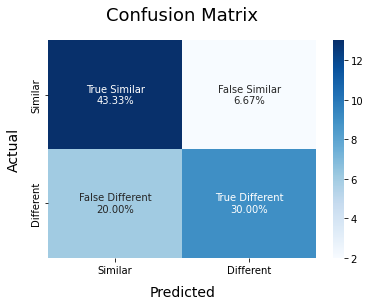

In [20]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)